#  EAD Adversarial Attack on Logistic Regression Model (German Credit Dataset)

In [1]:
# Import Libraries
from art.attacks.evasion import ElasticNet
from art.estimators.classification import SklearnClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

C:\Users\baberra\AppData\Local\anaconda3\Lib\site-packages\art\estimators\certification\__init__.py:30: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [2]:
# Load the trained model and test data (Ensure the model/data were saved in previous training notebook)
model = joblib.load("../../../../saved_models/credit_scoring_model_german_dataset---logistic_regression.joblib")
X_test = joblib.load("../../../../saved_models/credit_scoring_model_german_dataset---logistic_regression-X_test.joblib")
y_test = joblib.load("../../../../saved_models/credit_scoring_model_german_dataset---logistic_regression-y_test.joblib")

In [3]:
# Wrap the model with ART's SklearnClassifier
art_classifier = SklearnClassifier(model=model)

In [4]:
# === Clean Evaluation ===
y_pred_clean = art_classifier.predict(X_test.to_numpy())
y_pred_clean_labels = np.argmax(y_pred_clean, axis=1)
acc_clean = accuracy_score(y_test, y_pred_clean_labels)
cm_clean = confusion_matrix(y_test, y_pred_clean_labels)

In [5]:
# Adversarial examples using EAD
ead = ElasticNet(
    classifier=art_classifier,
    targeted=False,
    max_iter=100,             # Increase this for more aggressive attacks
    binary_search_steps=7,    # Increase for better success rate
    learning_rate=0.1,
    initial_const=0.0001,
    beta=0.1,                # L1 regularization factor (higher = sparser perturbations)
    decision_rule='EN'       # Elastic Net decision rule
)

X_test_adv = ead.generate(x=X_test.to_numpy())

# Use .values to convert DataFrame to NumPy array
X_test_adv = ead.generate(x=X_test.values)

EAD:   0%|          | 0/200 [00:00<?, ?it/s]

EAD:   0%|          | 0/200 [00:00<?, ?it/s]

In [6]:
# Evaluate the model on adversarial examples
y_pred_adv = art_classifier.predict(X_test_adv)
y_pred_adv_labels = np.argmax(y_pred_adv, axis=1)

acc_adv = accuracy_score(y_test, y_pred_adv_labels)
cm_adv = confusion_matrix(y_test, y_pred_adv_labels)
report = classification_report(y_test, y_pred_adv_labels)

# Compare performance
print(f"Accuracy on Clean Examples: {acc_clean:.4f}")
print(f"Accuracy on Adversarial Examples: {acc_adv:.4f}")
print(f"Attack Success Rate: {(acc_clean - acc_adv) / acc_clean * 100:.2f}%")
print("\nClassification Report on Adversarial Examples:\n", report)

# Check Perturbation Magnitude
perturbation = np.mean(np.abs(X_test_adv - X_test.values))
print("Average Perturbation per Feature:", perturbation)

Accuracy on Clean Examples: 0.7300
Accuracy on Adversarial Examples: 0.2700
Attack Success Rate: 63.01%

Classification Report on Adversarial Examples:
               precision    recall  f1-score   support

           0       0.42      0.11      0.17       140
           1       0.24      0.65      0.35        60

    accuracy                           0.27       200
   macro avg       0.33      0.38      0.26       200
weighted avg       0.36      0.27      0.22       200

Average Perturbation per Feature: 0.06143388972024285


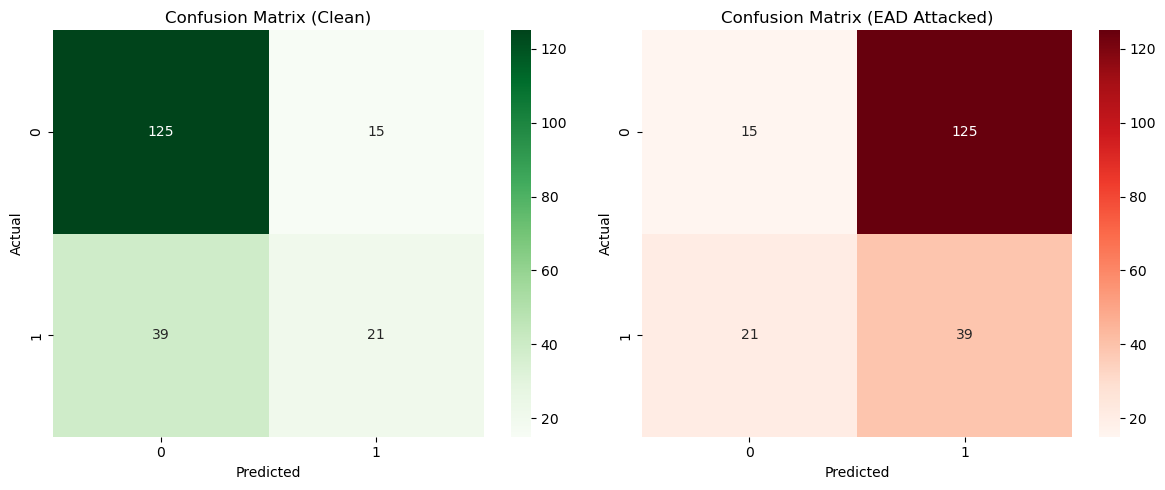

In [7]:
# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_clean, annot=True, fmt='d', cmap="Greens", ax=axes[0])
axes[0].set_title("Confusion Matrix (Clean)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_adv, annot=True, fmt='d', cmap="Reds", ax=axes[1])
axes[1].set_title("Confusion Matrix (EAD Attacked)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [8]:
# Sample Predictions on Adversarial Examples
X_test_sample = X_test.copy()
results_df = X_test_sample.copy()
results_df['Actual'] = y_test.values
results_df['Predicted'] = y_pred_adv_labels
results_df['Correct'] = results_df['Actual'] == results_df['Predicted']

columns_to_show = ['Actual', 'Predicted', 'Correct', 'Age', 'Credit amount', 'Duration',
                   'Job_1', 'Job_2', 'Job_3', 'Housing_own', 'Housing_rent']
results_df_subset = results_df[columns_to_show]

print("\nRandom Sample Predictions:")
results_df_subset.sample(10, random_state=42)


Random Sample Predictions:


,Actual,Predicted,Correct,Age,Credit amount,Duration,Job_1,Job_2,Job_3,Housing_own,Housing_rent
662,0,1,False,1.329562,-0.355028,0.019475,False,True,False,True,False
430,0,1,False,3.503789,0.096714,-1.335316,True,False,False,True,False
551,0,1,False,0.876598,-0.538794,-1.250642,True,False,False,True,False
263,0,1,False,1.963712,-0.165274,-0.742595,True,False,False,False,False
347,0,1,False,-1.116443,0.212738,0.273499,False,False,False,False,True
89,1,1,True,-0.663479,-0.779075,-0.742595,False,True,False,True,False
141,0,0,True,-0.482293,0.600855,1.289592,False,False,True,True,False
563,1,1,True,0.151856,3.443052,1.289592,False,True,False,False,False
28,0,1,False,-0.119922,-0.289905,-1.165967,False,True,False,True,False
933,0,1,False,0.604820,-0.998396,-0.742595,False,True,False,True,False
